In [1]:
import pandas as pd
import networkx as nx
import math
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np

SNA DELLA PORT SCAN

In [2]:
# Caricamento file
PATH = "C:/Users/nicde/OneDrive/Desktop/Università/Ancona/DS/Data-Science/datasets/GeneratedLabelledFlows/TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"

df = pd.read_csv(PATH)

# Pulisce i nomi delle colonne rimuovendo spazi all'inizio e alla fine
df.columns = df.columns.str.strip()

# Assicurati che Timestamp sia in formato datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Crea una colonna che raggruppa per Ora e Minuto
df['Time_Key'] = df['Timestamp'].dt.strftime('%H:%M')

# Conta gli attacchi per ogni minuto reale della giornata
attacchi_per_minuto = df[df['Label'] != 'BENIGN'].groupby('Time_Key').size()

if attacchi_per_minuto.empty:
    print("Nessun attacco trovato")
else:
    print("Distribuzione attacchi per minuto:")
    print(attacchi_per_minuto)

Distribuzione attacchi per minuto:
Time_Key
01:05        5
01:06        2
01:52        1
01:55       30
01:56       45
01:57       29
01:58       11
01:59       62
02:00       49
02:14       70
02:15       64
02:16        4
02:51    10916
02:52    43603
02:53     3957
02:54    34620
02:55    44410
02:56      987
03:03        2
03:08     5002
03:09     4025
03:10     2009
03:12        1
03:13        1
03:21        1
03:22     5014
03:23     4010
dtype: int64


In [3]:
# Filtra il dataset per la finestra temporale del picco
df_portscan = df[(df['Time_Key'] >= '02:51') & (df['Time_Key'] <= '02:56')].copy()

print(f"Numero di flussi estratti: {len(df_portscan)}")
print(df_portscan['Label'].value_counts())



Numero di flussi estratti: 143770
Label
PortScan    138493
BENIGN        5277
Name: count, dtype: int64


In [4]:
# Definiamo l'inizio e la fine basandoci sui picchi trovati
# Usiamo l'ora del giorno specifica del file Friday
start_time_attack = df['Timestamp'].dt.normalize() + pd.Timedelta(hours=2, minutes=51)
end_time_attack = start_time_attack + pd.Timedelta(minutes=5) # 5 minuti di attacco

#Filtriamo il DataFrame
df_5min = df[
    (df['Timestamp'] >= start_time_attack) & 
    (df['Timestamp'] < end_time_attack)
].copy()

if "Label" in df_5min.columns:
    print("\nDistribuzione etichette nella finestra scelta:")
    print(df_5min["Label"].value_counts())


Distribuzione etichette nella finestra scelta:
Label
PortScan    137506
BENIGN        4762
Name: count, dtype: int64


In [5]:
# Estrazione archi diretti (flow direction: Src IP -> Dst IP)
edges = df_5min[["Source IP", "Destination IP"]].dropna()

# Aggregazione: conteggio flussi per coppia (Src IP, Dst IP)
edges_w = (
    edges.groupby(["Source IP", "Destination IP"])
         .size()
         .reset_index(name="weight")
)

# Lista IP unici (sorgenti e destinazioni)
ips = pd.unique(edges_w[["Source IP", "Destination IP"]].values.ravel())

# Mappa IP -> ID intero
ip_to_id = {ip: i for i, ip in enumerate(ips)}

# Applica mappatura
edges_w["src_id"] = edges_w["Source IP"].map(ip_to_id)
edges_w["dst_id"] = edges_w["Destination IP"].map(ip_to_id)

mapping_df = pd.DataFrame({"ip": list(ip_to_id.keys()), "id": list(ip_to_id.values())})
mapping_df.to_csv("ip_id_mapping_port_scan_5m.csv", index=False)

In [6]:
# Salvataggio file di archi pesati
EDGE_TXT = "cic_port_scan_5m_edges_weighted.txt"

edges_w[["src_id", "dst_id", "weight"]].to_csv(
    EDGE_TXT,
    sep=" ",
    index=False,
    header=False
)

In [8]:
#Creazione del grafo con NetworkX
data = pd.read_csv(EDGE_TXT, sep=" ", header=None, names=["src", "target", "weight"])

G = nx.DiGraph()
for _, r in data.iterrows():
    G.add_edge(int(r["src"]), int(r["target"]), weight=int(r["weight"]))

In [9]:
# Analisi del grafo
def analizza_grafo_diretto_pesato(G: nx.DiGraph, weight_attr: str = "weight"):
    """
    Analisi base per grafo DIRETTO e PESATO.
    Per distanze (raggio/diametro) si usa un costo inverso: cost = 1/weight.
    """
    if not isinstance(G, (nx.DiGraph, nx.MultiDiGraph)):
        raise TypeError("Questa funzione è pensata per grafi diretti (DiGraph/MultiDiGraph).")

    # Nodi e archi
    n_nodi = G.number_of_nodes()
    n_archi = G.number_of_edges()

    # Densità (per grafi diretti NetworkX gestisce la formula corretta)
    densita = nx.density(G)

    # Connettività (diretto): debole vs forte
    weakly = nx.is_weakly_connected(G) if n_nodi > 0 else False
    strongly = nx.is_strongly_connected(G) if n_nodi > 0 else False

    # Clustering: su diretti spesso si riporta sul grafo "semplificato" non diretto
    # (approccio standard quando si confronta con esempi di Graph non orientati)
    G_u = G.to_undirected()
    clustering_medio = nx.average_clustering(G_u)

    # Raggio/diametro/periferia: calcolabili solo su un grafo connesso (qui: componente connessa massima)
    # e con una metrica di distanza coerente con i pesi:
    # weight = numero di flussi (forza) -> cost = 1/weight (più flussi => distanza minore)
    raggio = diametro = periferia = None

    if n_nodi > 0 and G_u.number_of_edges() > 0:
        # Componente connessa più grande (su grafo non diretto)
        largest_cc_nodes = max(nx.connected_components(G_u), key=len)
        H = G_u.subgraph(largest_cc_nodes).copy()

        # Costruzione attributo 'cost' = 1/weight (gestione robusta)
        for u, v, data in H.edges(data=True):
            w = data.get(weight_attr, 1)
            try:
                w = float(w)
            except Exception:
                w = 1.0
            data["cost"] = (1.0 / w) if w > 0 else math.inf

        # Se la componente ha almeno 2 nodi si possono calcolare eccentricità/raggio/diametro
        if H.number_of_nodes() >= 2:
            # eccentricity usa 'distance' come nome parametro
            ecc = nx.eccentricity(H, weight="cost")
            raggio = min(ecc.values())
            diametro = max(ecc.values())
            periferia = [n for n, e in ecc.items() if e == diametro]

    # Stampa risultati
    print(f"Numero di nodi: {n_nodi}")
    print(f"Numero di archi: {n_archi}")
    print(f"Densità (diretto): {densita:.6f}")
    print(f"Connesso (debole / weakly): {weakly}")
    print(f"Connesso (forte / strongly): {strongly}")
    print(f"Average clustering coefficient (su versione non diretta): {clustering_medio:.6f}")

    if raggio is not None:
        print("Raggio/Diametro/Periferia calcolati sulla componente connessa più grande (versione non diretta),")
        print("usando cost=1/weight (più flussi => distanza minore).")
        print(f"Raggio: {raggio}")
        print(f"Diametro: {diametro}")
        print(f"Periferia: {periferia}")
    else:
        print("Raggio, diametro e periferia non calcolati (grafo vuoto/non connesso o componente troppo piccola).")


In [10]:
analizza_grafo_diretto_pesato(G, weight_attr="weight")

Numero di nodi: 422
Numero di archi: 790
Densità (diretto): 0.004447
Connesso (debole / weakly): False
Connesso (forte / strongly): False
Average clustering coefficient (su versione non diretta): 0.002292
Raggio/Diametro/Periferia calcolati sulla componente connessa più grande (versione non diretta),
usando cost=1/weight (più flussi => distanza minore).
Raggio: 1.125
Diametro: 2.2019230769230766
Periferia: [350, 351, 352, 406]


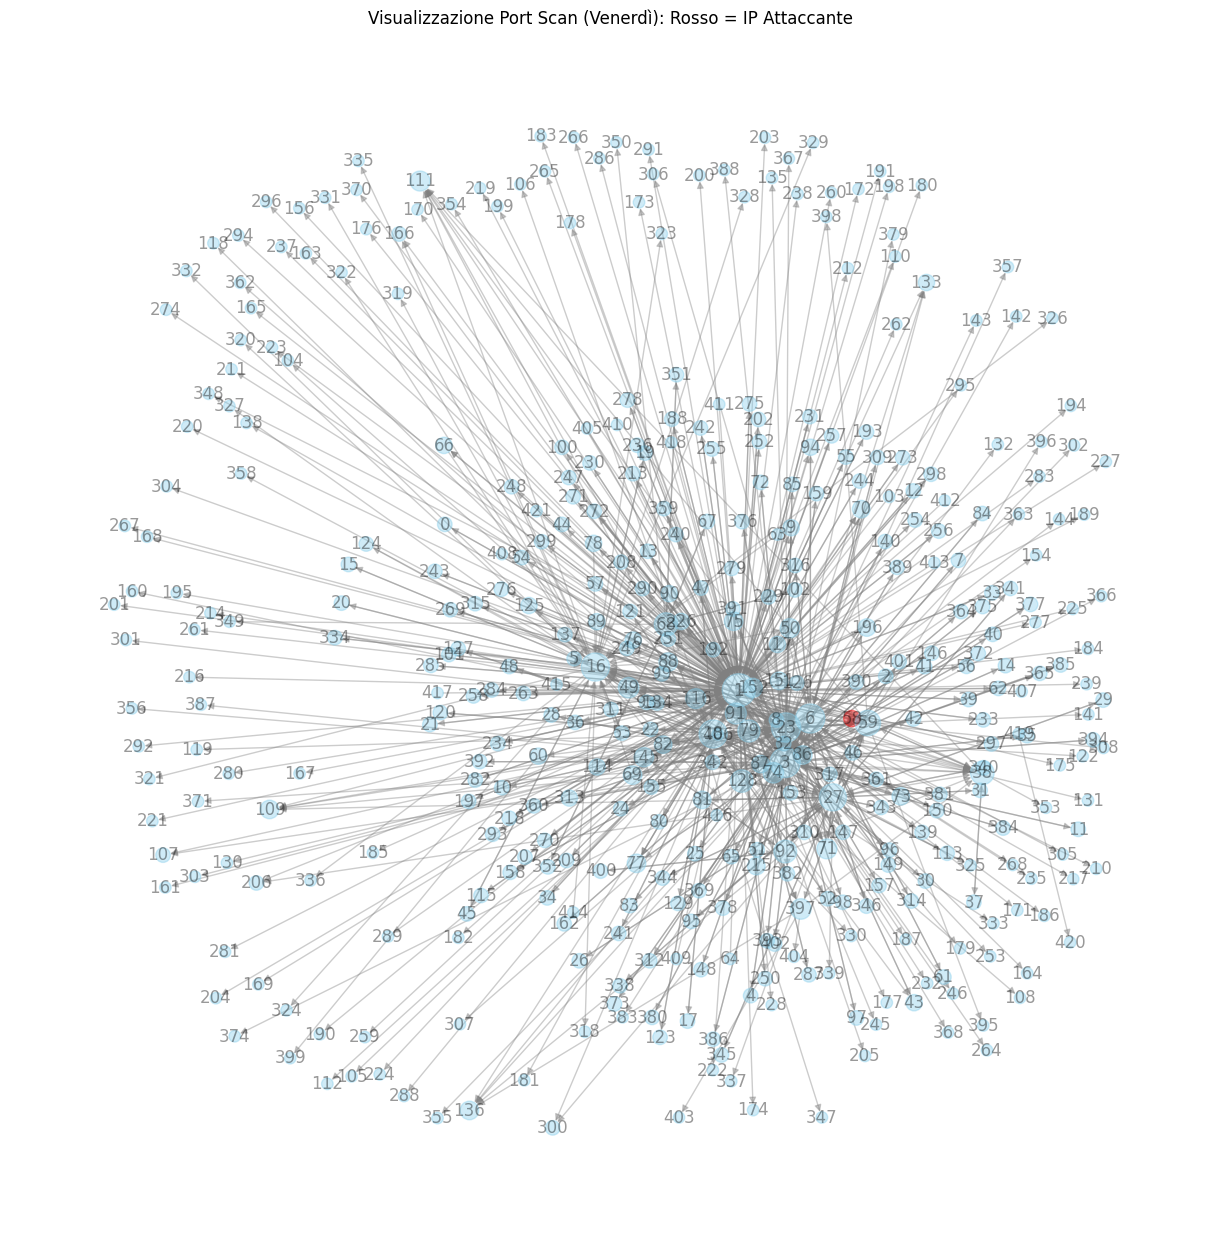

In [11]:
# Identifica l'IP dell'attaccante usando la mappa IP->ID
node_labels = {}
for _, row in df_5min.iterrows():
    label_pulita = str(row['Label']).strip()
    if label_pulita != 'BENIGN':
        ip_attaccante = row['Source IP']
        if ip_attaccante in ip_to_id:
            id_attaccante = ip_to_id[ip_attaccante]
            node_labels[id_attaccante] = 'Attack'


# Creazione della lista colori basata sugli ID
colors = []
contatore_rossi = 0
for node in G.nodes():
    if node in node_labels:
        colors.append('red')
        contatore_rossi += 1
    else:
        colors.append('skyblue')


# Visualizzazione (con dimensioni logaritmiche per il PortScan)
d = dict(G.degree)
node_sizes = [np.log1p(v) * 100 for v in d.values()]

pos = nx.spring_layout(G, k=0.15, iterations=20) 

plt.figure(figsize=(12, 12))
nx.draw(G, pos, 
        node_size=node_sizes, 
        node_color=colors, 
        with_labels=True, # Metti True se vuoi vedere l'ID numerico dell'attaccante
        edge_color='gray',
        alpha=0.4)

plt.title("Visualizzazione Port Scan (Venerdì): Rosso = IP Attaccante")
plt.show()

Nodi nella componente d'attacco: 420
Archi nella componente d'attacco: 789


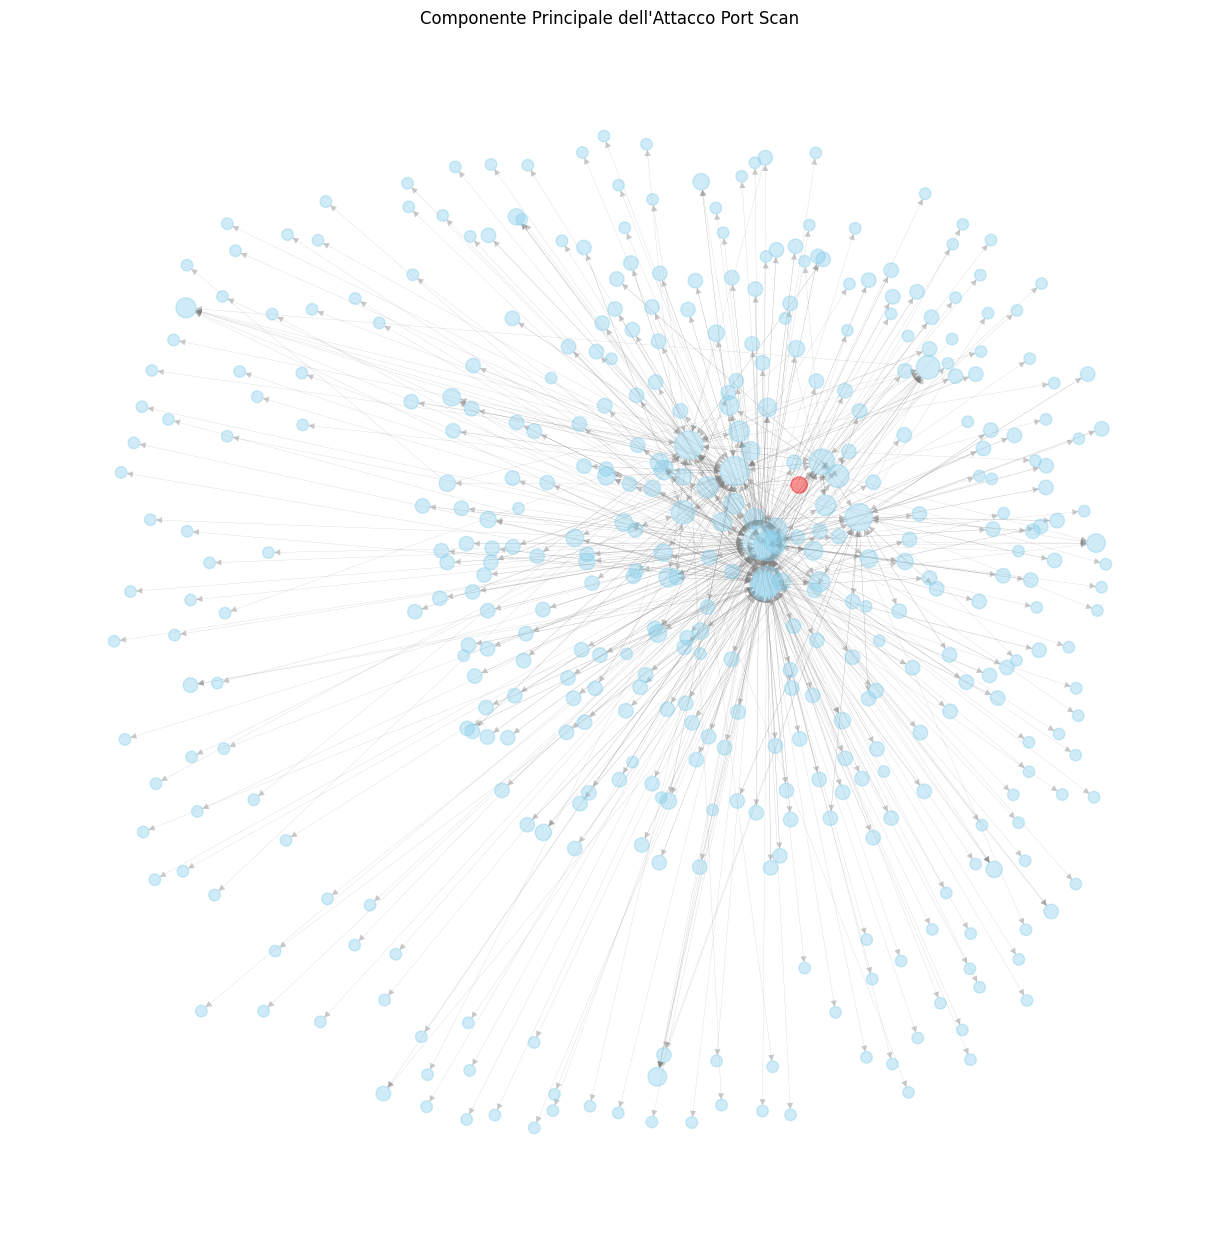

In [13]:
# Estrai la componente debolmente connessa più grande
largest_wcc = max(nx.weakly_connected_components(G), key=len)
H = G.subgraph(largest_wcc).copy()

print(f"Nodi nella componente d'attacco: {H.number_of_nodes()}")
print(f"Archi nella componente d'attacco: {H.number_of_edges()}")

# Ricalcola i colori solo per i nodi presenti in H
colors_H = []
for node in H.nodes():
    if node in node_labels: # node_labels contiene gli ID degli attaccanti
        colors_H.append('red')
    else:
        colors_H.append('skyblue')

# Ricalcola le dimensioni solo per i nodi in H
d_H = dict(H.degree)
node_sizes_H = [np.log1p(v) * 100 for v in d_H.values()]

# Visualizzazione di H
pos = nx.spring_layout(H, k=0.15, iterations=20)
plt.figure(figsize=(12, 12))
nx.draw(H, pos, 
        node_size=node_sizes_H, 
        node_color=colors_H, 
        edge_color='gray',
        alpha=0.4,
        width=0.2)
plt.title("Componente Principale dell'Attacco Port Scan")
plt.show()

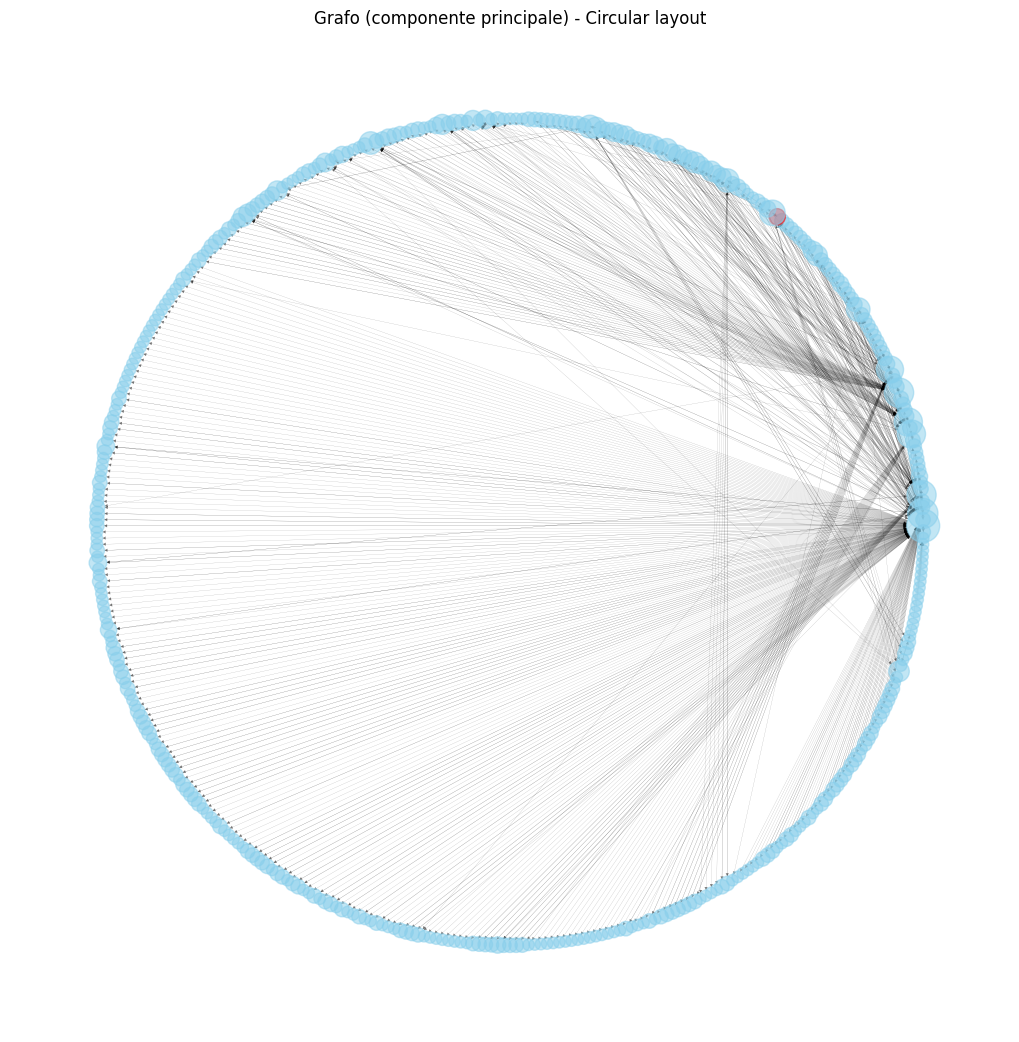

In [14]:
# Visualizzazione circular 
pos = nx.circular_layout(H.to_undirected())

plt.figure(figsize=(10, 10))
nx.draw(H, pos, 
        with_labels=False, 
        node_size=node_sizes_H, # Usa le dimensioni pesate sul grado
        node_color=colors_H,    # Usa la lista con l'attaccante rosso
        arrows=True, 
        arrowsize=5,            # Leggermente più piccole se gli archi sono troppi
        width=0.1,              # Archi sottili per evitare il "muro" di colore
        alpha=0.5)
plt.title("Grafo (componente principale) - Circular layout")
plt.axis("off")
plt.show()

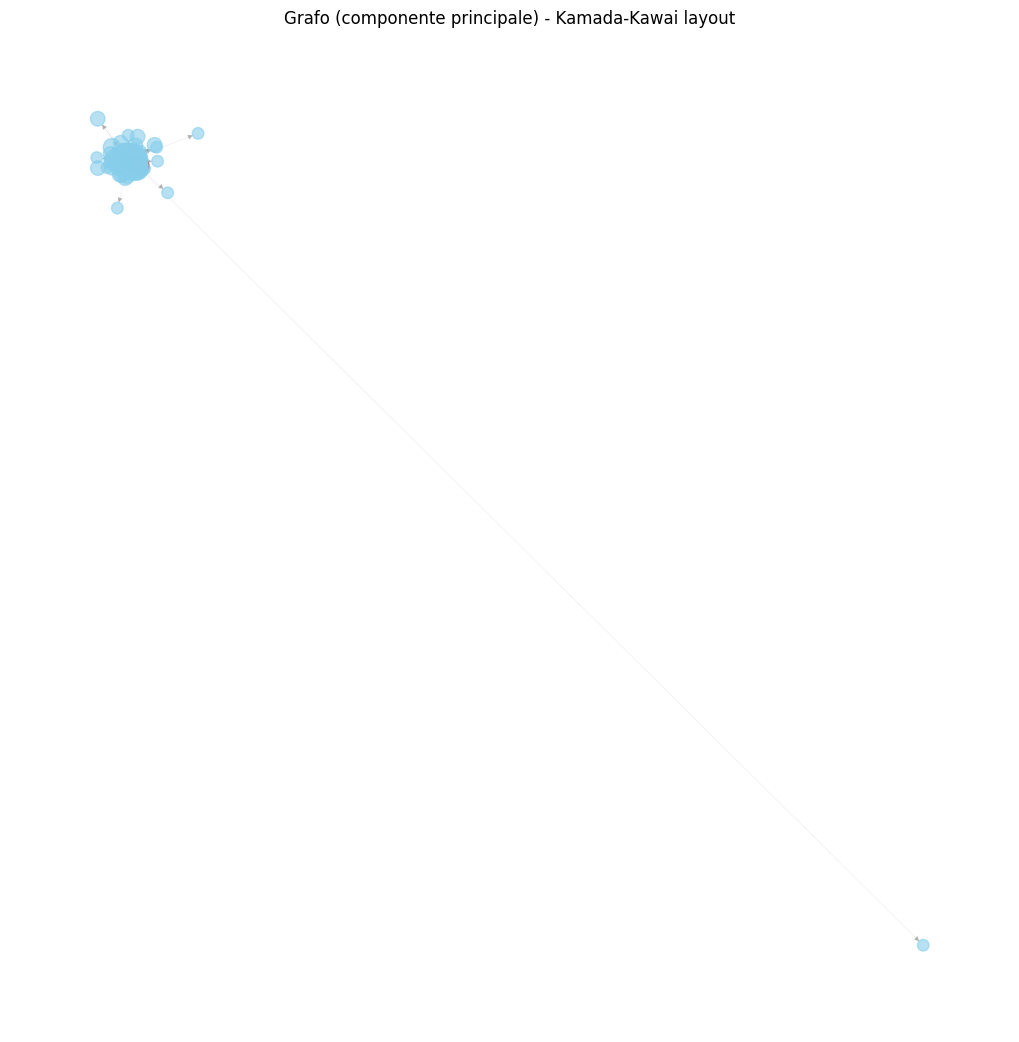

In [15]:
# Visualizzazione kamada-kawai
pos = nx.kamada_kawai_layout(H.to_undirected())

plt.figure(figsize=(10, 10))
nx.draw(H, pos, 
        with_labels=False, 
        node_size=node_sizes_H, # Dimensione basata sul grado logaritmico
        node_color=colors_H,    # Rosso per l'attaccante
        arrows=True, 
        arrowsize=8, 
        edge_color='gray',
        width=0.1,              # Molto sottile per gestire i grandi numeri
        alpha=0.6)
plt.title("Grafo (componente principale) - Kamada-Kawai layout")
plt.axis("off")
plt.show()

In [16]:
# Costruisci un grafo non diretto per closeness/betweenness/eigenvector "stabili" 
U = H.to_undirected()

# Crea 'cost' = 1/weight (weight = numero flussi => più flussi = più vicinanza)
for u, v, data in U.edges(data=True):
    w = data.get("weight", 1)
    try:
        w = float(w)
    except Exception:
        w = 1.0
    data["cost"] = (1.0 / w) if w > 0 else math.inf

# Centralità
# Degree: su grafo diretto ha più senso separare in/out (in più ti calcolo anche degree_centrality "classica" su U)
in_deg_cent = {n: d/(H.number_of_nodes()-1) for n, d in H.in_degree()}
out_deg_cent = {n: d/(H.number_of_nodes()-1) for n, d in H.out_degree()}
degree_centrality = nx.degree_centrality(U)

# Closeness e betweenness: usa cost come distanza (NOTA: per la tua versione NX closeness usa 'distance', betweenness usa 'weight')
# Se la tua version di closeness non accetta 'distance', usa la riga alternativa commentata sotto.
try:
    closeness_centrality = nx.closeness_centrality(U, distance="cost")
except TypeError:
    # fallback per versioni vecchie: calcolo non pesato (topologia) se 'distance' non è supportato
    closeness_centrality = nx.closeness_centrality(U)

betweenness_centrality = nx.betweenness_centrality(U, weight="cost")

# Eigenvector: su grafo non diretto è più robusta; i pesi qui puoi usarli come intensità (weight="weight")
# Se non converge, aumenta max_iter o usa eigenvector_centrality_numpy.
try:
    eigenvector_centrality = nx.eigenvector_centrality(U, weight="weight", max_iter=2000)
except nx.PowerIterationFailedConvergence:
    eigenvector_centrality = nx.eigenvector_centrality_numpy(U, weight="weight")

# 4) DataFrame (come nel tuo esempio, con l'aggiunta di In/Out-degree)
centrality_df = pd.DataFrame({
    "Node": list(U.nodes),
    "In-Degree Centrality": [in_deg_cent[n] for n in U.nodes],
    "Out-Degree Centrality": [out_deg_cent[n] for n in U.nodes],
    "Degree Centrality": [degree_centrality[n] for n in U.nodes],
    "Closeness Centrality": [closeness_centrality[n] for n in U.nodes],
    "Betweenness Centrality": [betweenness_centrality[n] for n in U.nodes],
    "Eigenvector Centrality": [eigenvector_centrality[n] for n in U.nodes]
})

centrality_sorted_df = centrality_df.copy()
centrality_sorted_df["Node"] = centrality_sorted_df["Node"].astype(str)

# 5) Ordinamenti (come nel tuo esempio)
degree_sorted = centrality_sorted_df.sort_values("Degree Centrality", ascending=False)
print("degree_sorted done")

closeness_sorted = centrality_sorted_df.sort_values("Closeness Centrality", ascending=False)
print("closeness_sorted done")

betweenness_sorted = centrality_sorted_df.sort_values("Betweenness Centrality", ascending=False)
print("betweenness_sorted done")

eigenvector_sorted = centrality_sorted_df.sort_values("Eigenvector Centrality", ascending=False)
print("eigenvector_sorted done")

# (Opzionale) anche per in/out-degree
in_degree_sorted = centrality_sorted_df.sort_values("In-Degree Centrality", ascending=False)
print("in_degree_sorted done")

out_degree_sorted = centrality_sorted_df.sort_values("Out-Degree Centrality", ascending=False)
print("out_degree_sorted done")

# 6) Stampa top/bottom 5 come nel tuo esempio
print("Top 5 Degree Centrality:\n", degree_sorted.head(), "\n")
print("Bottom 5 Degree Centrality:\n", degree_sorted.tail(), "\n")

print("Top 5 Closeness Centrality:\n", closeness_sorted.head(), "\n")
print("Bottom 5 Closeness Centrality:\n", closeness_sorted.tail(), "\n")

print("Top 5 Betweenness Centrality:\n", betweenness_sorted.head(), "\n")
print("Bottom 5 Betweenness Centrality:\n", betweenness_sorted.tail(), "\n")

print("Top 5 Eigenvector Centrality:\n", eigenvector_sorted.head(), "\n")
print("Bottom 5 Eigenvector Centrality:\n", eigenvector_sorted.tail(), "\n")

# (Opzionale) top/bottom in/out-degree
print("Top 5 In-Degree Centrality:\n", in_degree_sorted.head(), "\n")
print("Top 5 Out-Degree Centrality:\n", out_degree_sorted.head(), "\n")

degree_sorted done
closeness_sorted done
betweenness_sorted done
eigenvector_sorted done
in_degree_sorted done
out_degree_sorted done
Top 5 Degree Centrality:
    Node  In-Degree Centrality  Out-Degree Centrality  Degree Centrality  \
1     1              0.243437               0.439141           0.477327   
3     3              0.109785               0.167064           0.167064   
23   23              0.078759               0.126492           0.128878   
16   16              0.062053               0.081146           0.114558   
6     6              0.083532               0.112172           0.112172   

    Closeness Centrality  Betweenness Centrality  Eigenvector Centrality  
1               1.363106                0.679692                0.297878  
3               1.357490                0.248929                0.169702  
23              1.355130                0.172532                0.137254  
16              1.330273                0.142808                0.037559  
6             

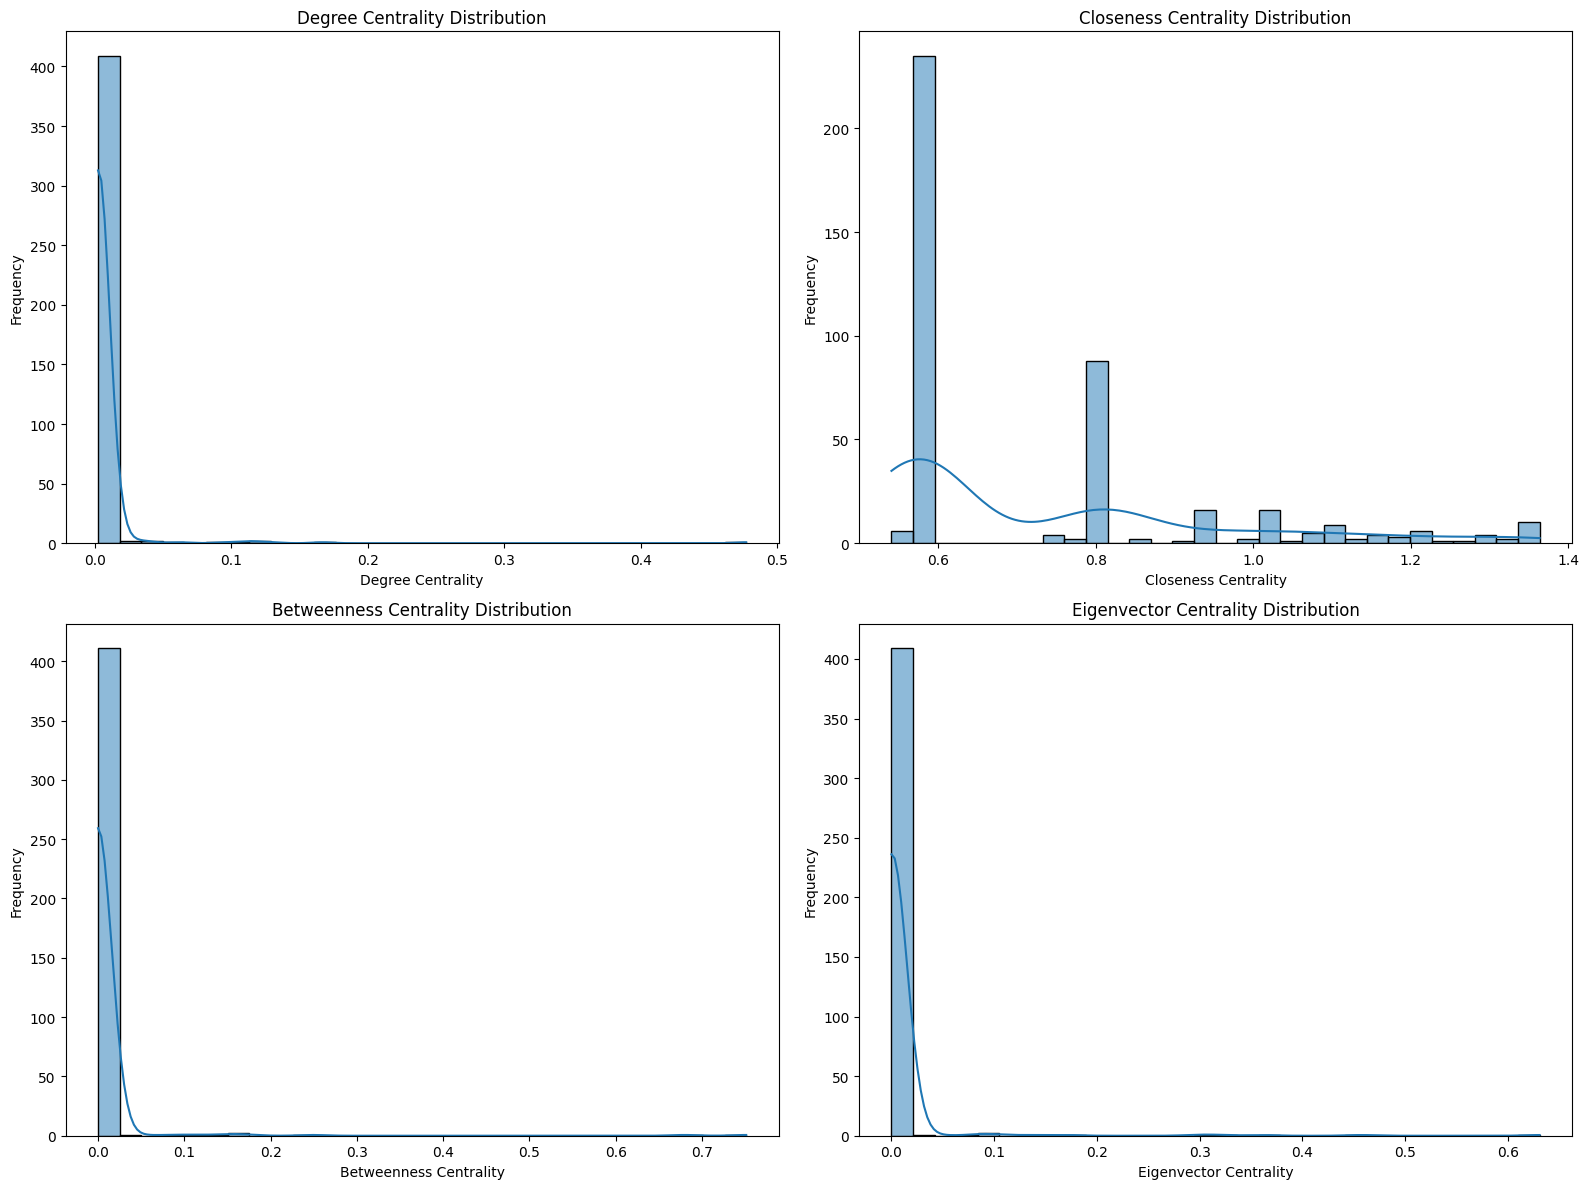

In [17]:
plt.figure(figsize=(16, 12))

# Degree Centrality
plt.subplot(2, 2, 1)
sns.histplot(
    degree_sorted["Degree Centrality"],
    kde=True,
    bins=30
)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")

# Closeness Centrality
plt.subplot(2, 2, 2)
sns.histplot(
    closeness_sorted["Closeness Centrality"],
    kde=True,
    bins=30
)
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")

# Betweenness Centrality
plt.subplot(2, 2, 3)
sns.histplot(
    betweenness_sorted["Betweenness Centrality"],
    kde=True,
    bins=30
)
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")

# Eigenvector Centrality
plt.subplot(2, 2, 4)
sns.histplot(
    eigenvector_sorted["Eigenvector Centrality"],
    kde=True,
    bins=30
)
plt.title("Eigenvector Centrality Distribution")
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

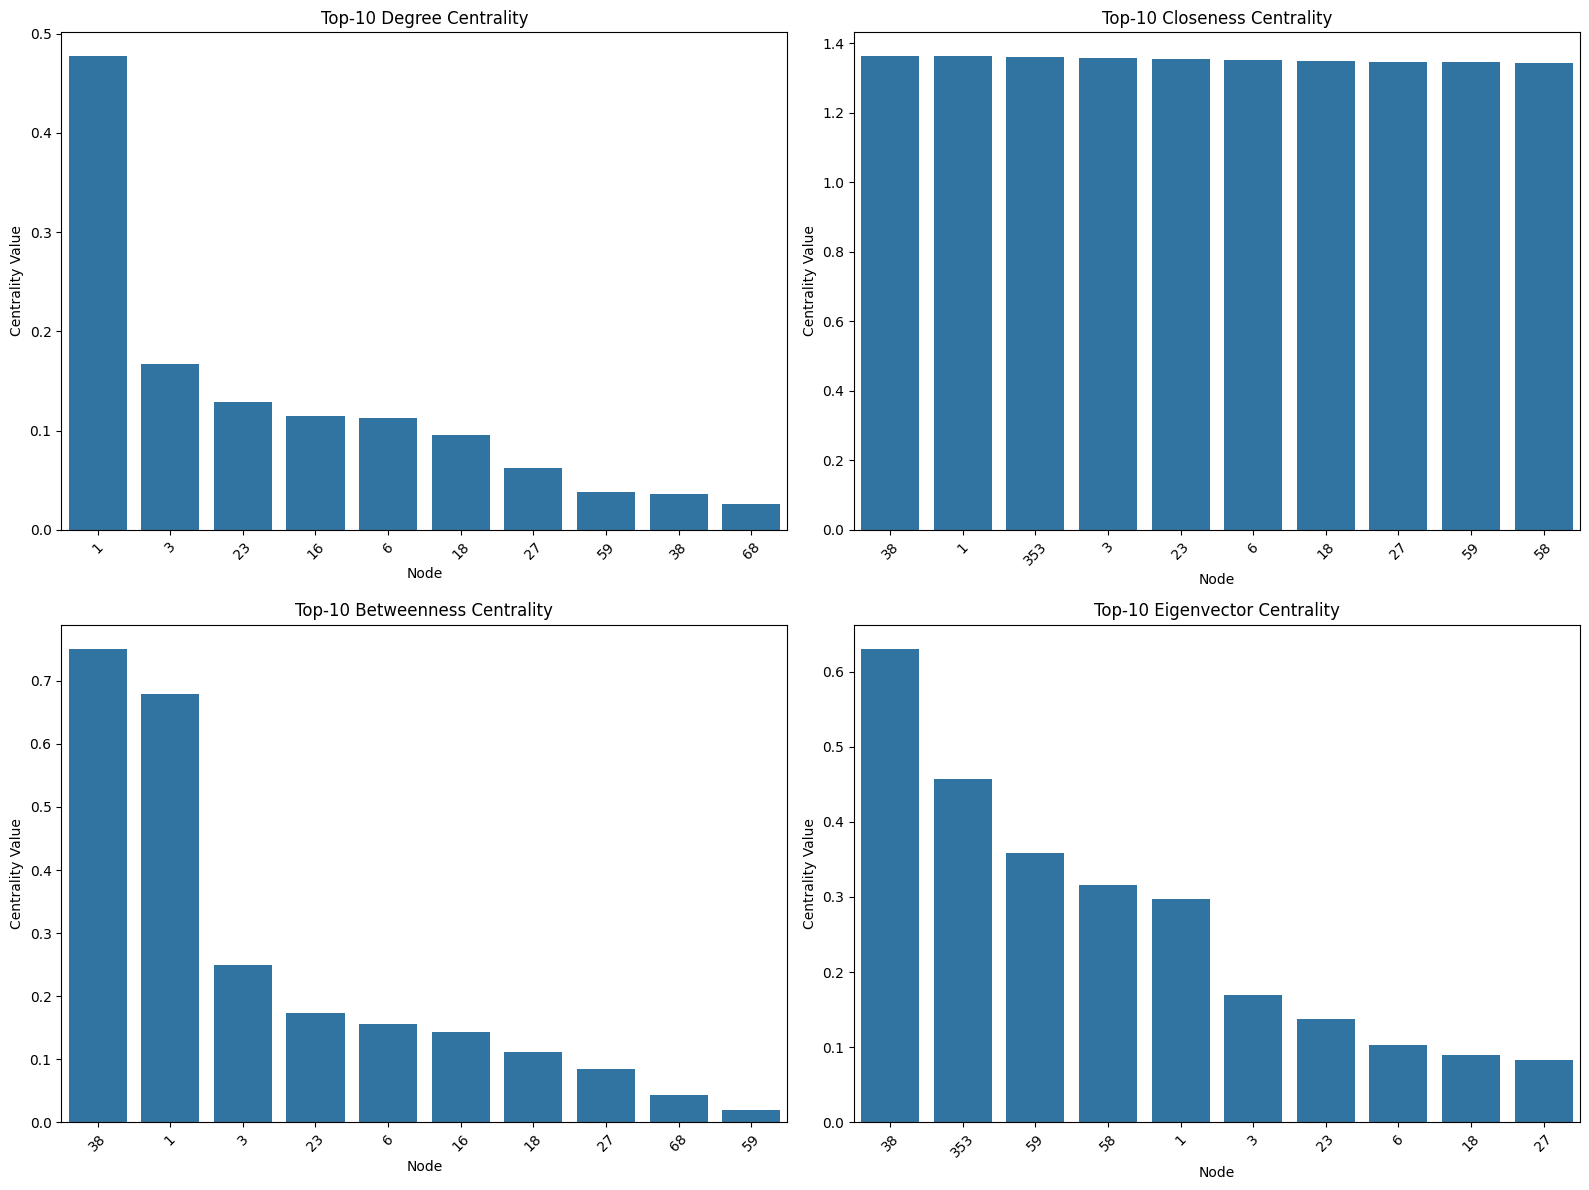

In [18]:
TOP_K = 10

plt.figure(figsize=(16, 12))

# Degree Centrality (top-k)
plt.subplot(2, 2, 1)
sns.barplot(
    x="Node",
    y="Degree Centrality",
    data=degree_sorted.head(TOP_K)
)
plt.title("Top-10 Degree Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Closeness Centrality (top-k)
plt.subplot(2, 2, 2)
sns.barplot(
    x="Node",
    y="Closeness Centrality",
    data=closeness_sorted.head(TOP_K)
)
plt.title("Top-10 Closeness Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Betweenness Centrality (top-k)
plt.subplot(2, 2, 3)
sns.barplot(
    x="Node",
    y="Betweenness Centrality",
    data=betweenness_sorted.head(TOP_K)
)
plt.title("Top-10 Betweenness Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

# Eigenvector Centrality (top-k)
plt.subplot(2, 2, 4)
sns.barplot(
    x="Node",
    y="Eigenvector Centrality",
    data=eigenvector_sorted.head(TOP_K)
)
plt.title("Top-10 Eigenvector Centrality")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

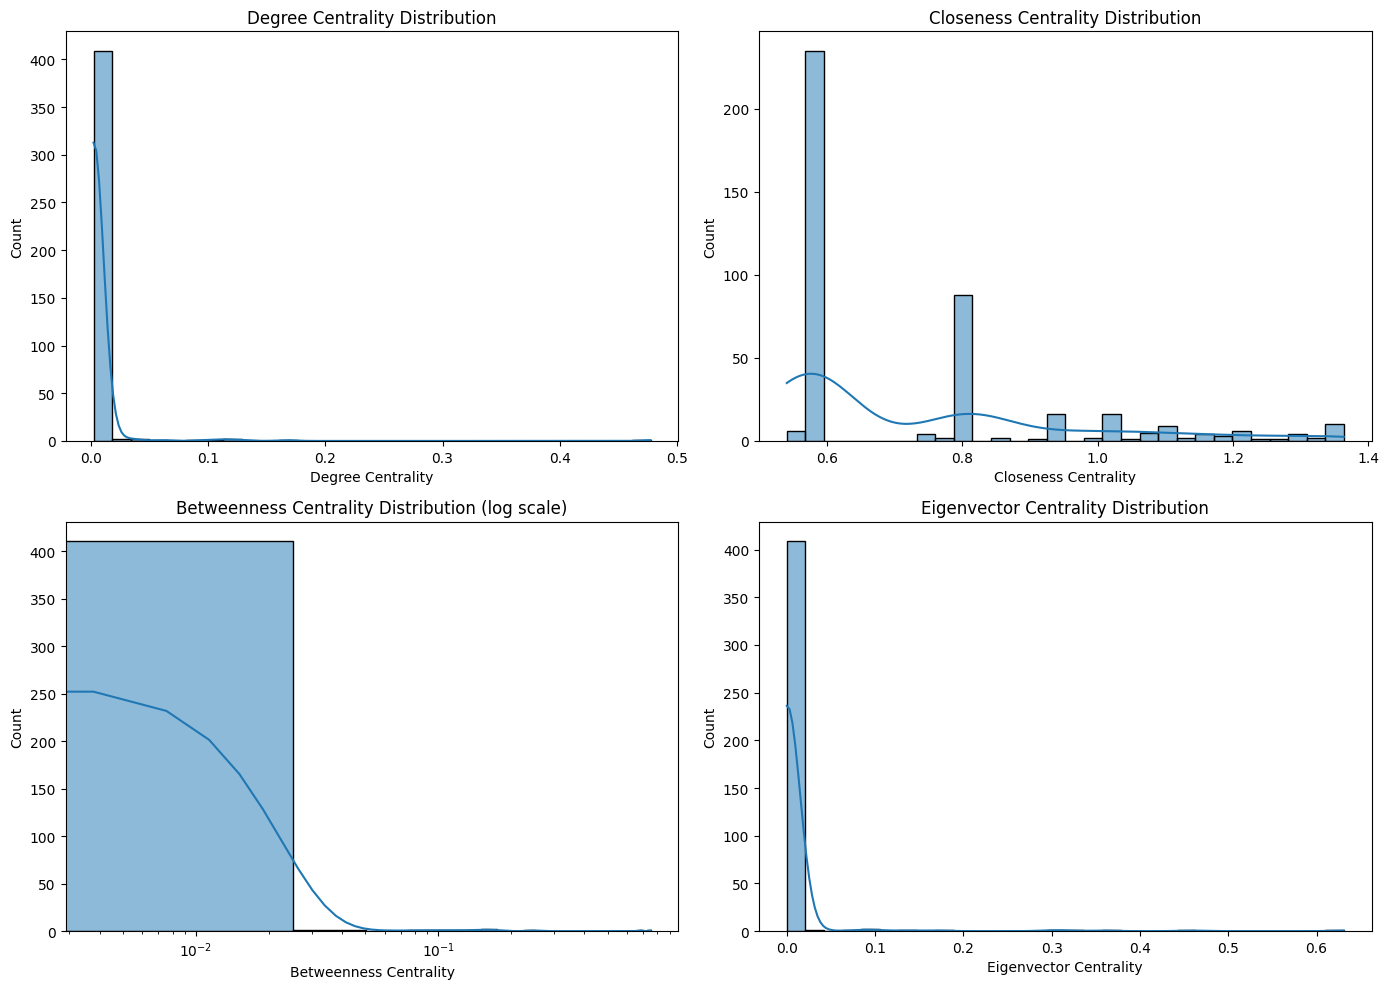

In [19]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.histplot(centrality_df["Degree Centrality"], kde=True, bins=30)
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 2)
sns.histplot(centrality_df["Closeness Centrality"], kde=True, bins=30)
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 3)
sns.histplot(centrality_df["Betweenness Centrality"], kde=True, bins=30)
plt.xscale("log")
plt.title("Betweenness Centrality Distribution (log scale)")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Count")

plt.subplot(2, 2, 4)
sns.histplot(centrality_df["Eigenvector Centrality"], kde=True, bins=30)
plt.title("Eigenvector Centrality Distribution")
plt.xlabel("Eigenvector Centrality")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


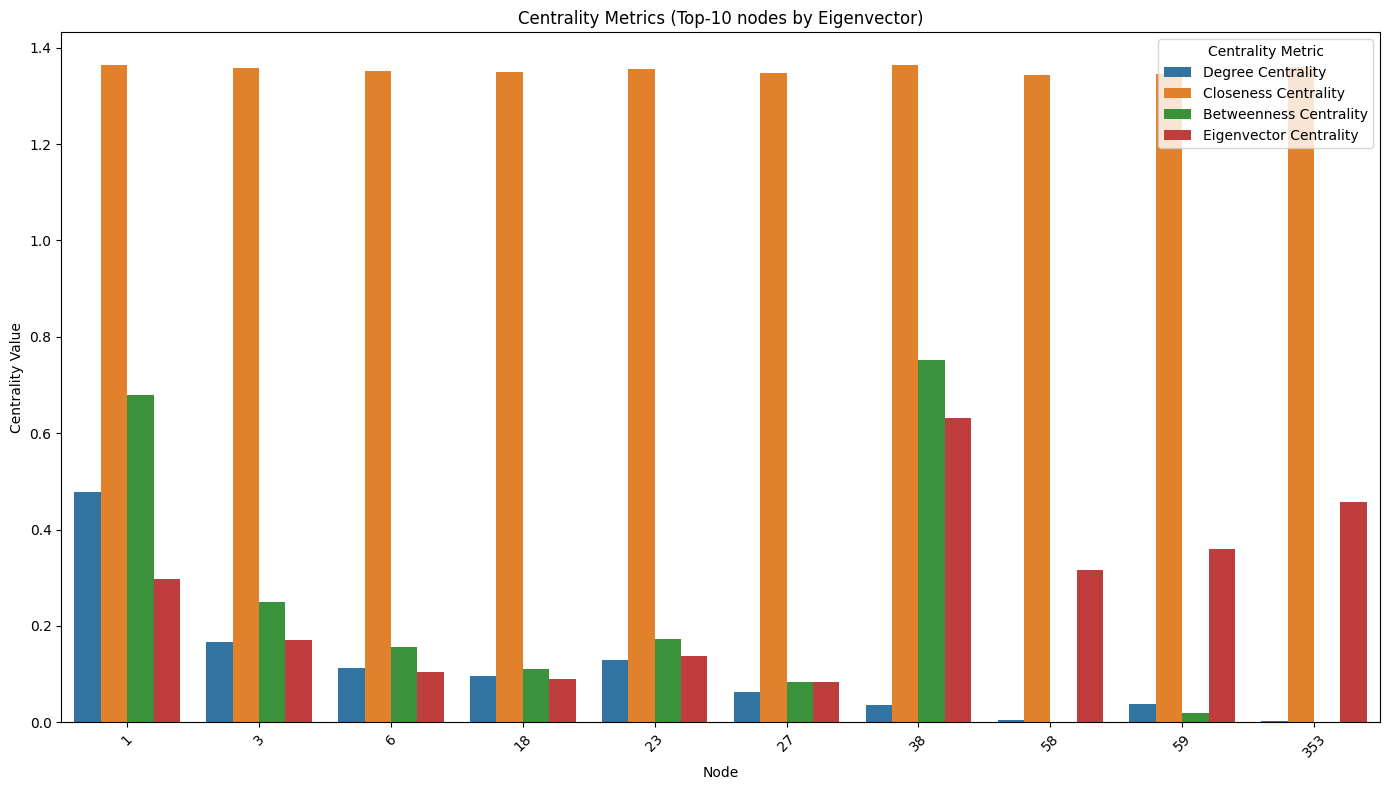

In [20]:
TOP_K = 10

# Assicura coerenza dei tipi
centrality_df_plot = centrality_df.copy()
centrality_df_plot["Node"] = centrality_df_plot["Node"].astype(str)

top_nodes = eigenvector_sorted.head(TOP_K)["Node"].astype(str)

centrality_topk = centrality_df_plot[centrality_df_plot["Node"].isin(top_nodes)]

centrality_melted = pd.melt(
    centrality_topk,
    id_vars="Node",
    value_vars=[
        "Degree Centrality",
        "Closeness Centrality",
        "Betweenness Centrality",
        "Eigenvector Centrality"
    ],
    var_name="Centrality Metric",
    value_name="Value"
)


plt.figure(figsize=(14, 8))
sns.barplot(
    data=centrality_melted,
    x="Node",
    y="Value",
    hue="Centrality Metric"
)
plt.title("Centrality Metrics (Top-10 nodes by Eigenvector)")
plt.xlabel("Node")
plt.ylabel("Centrality Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



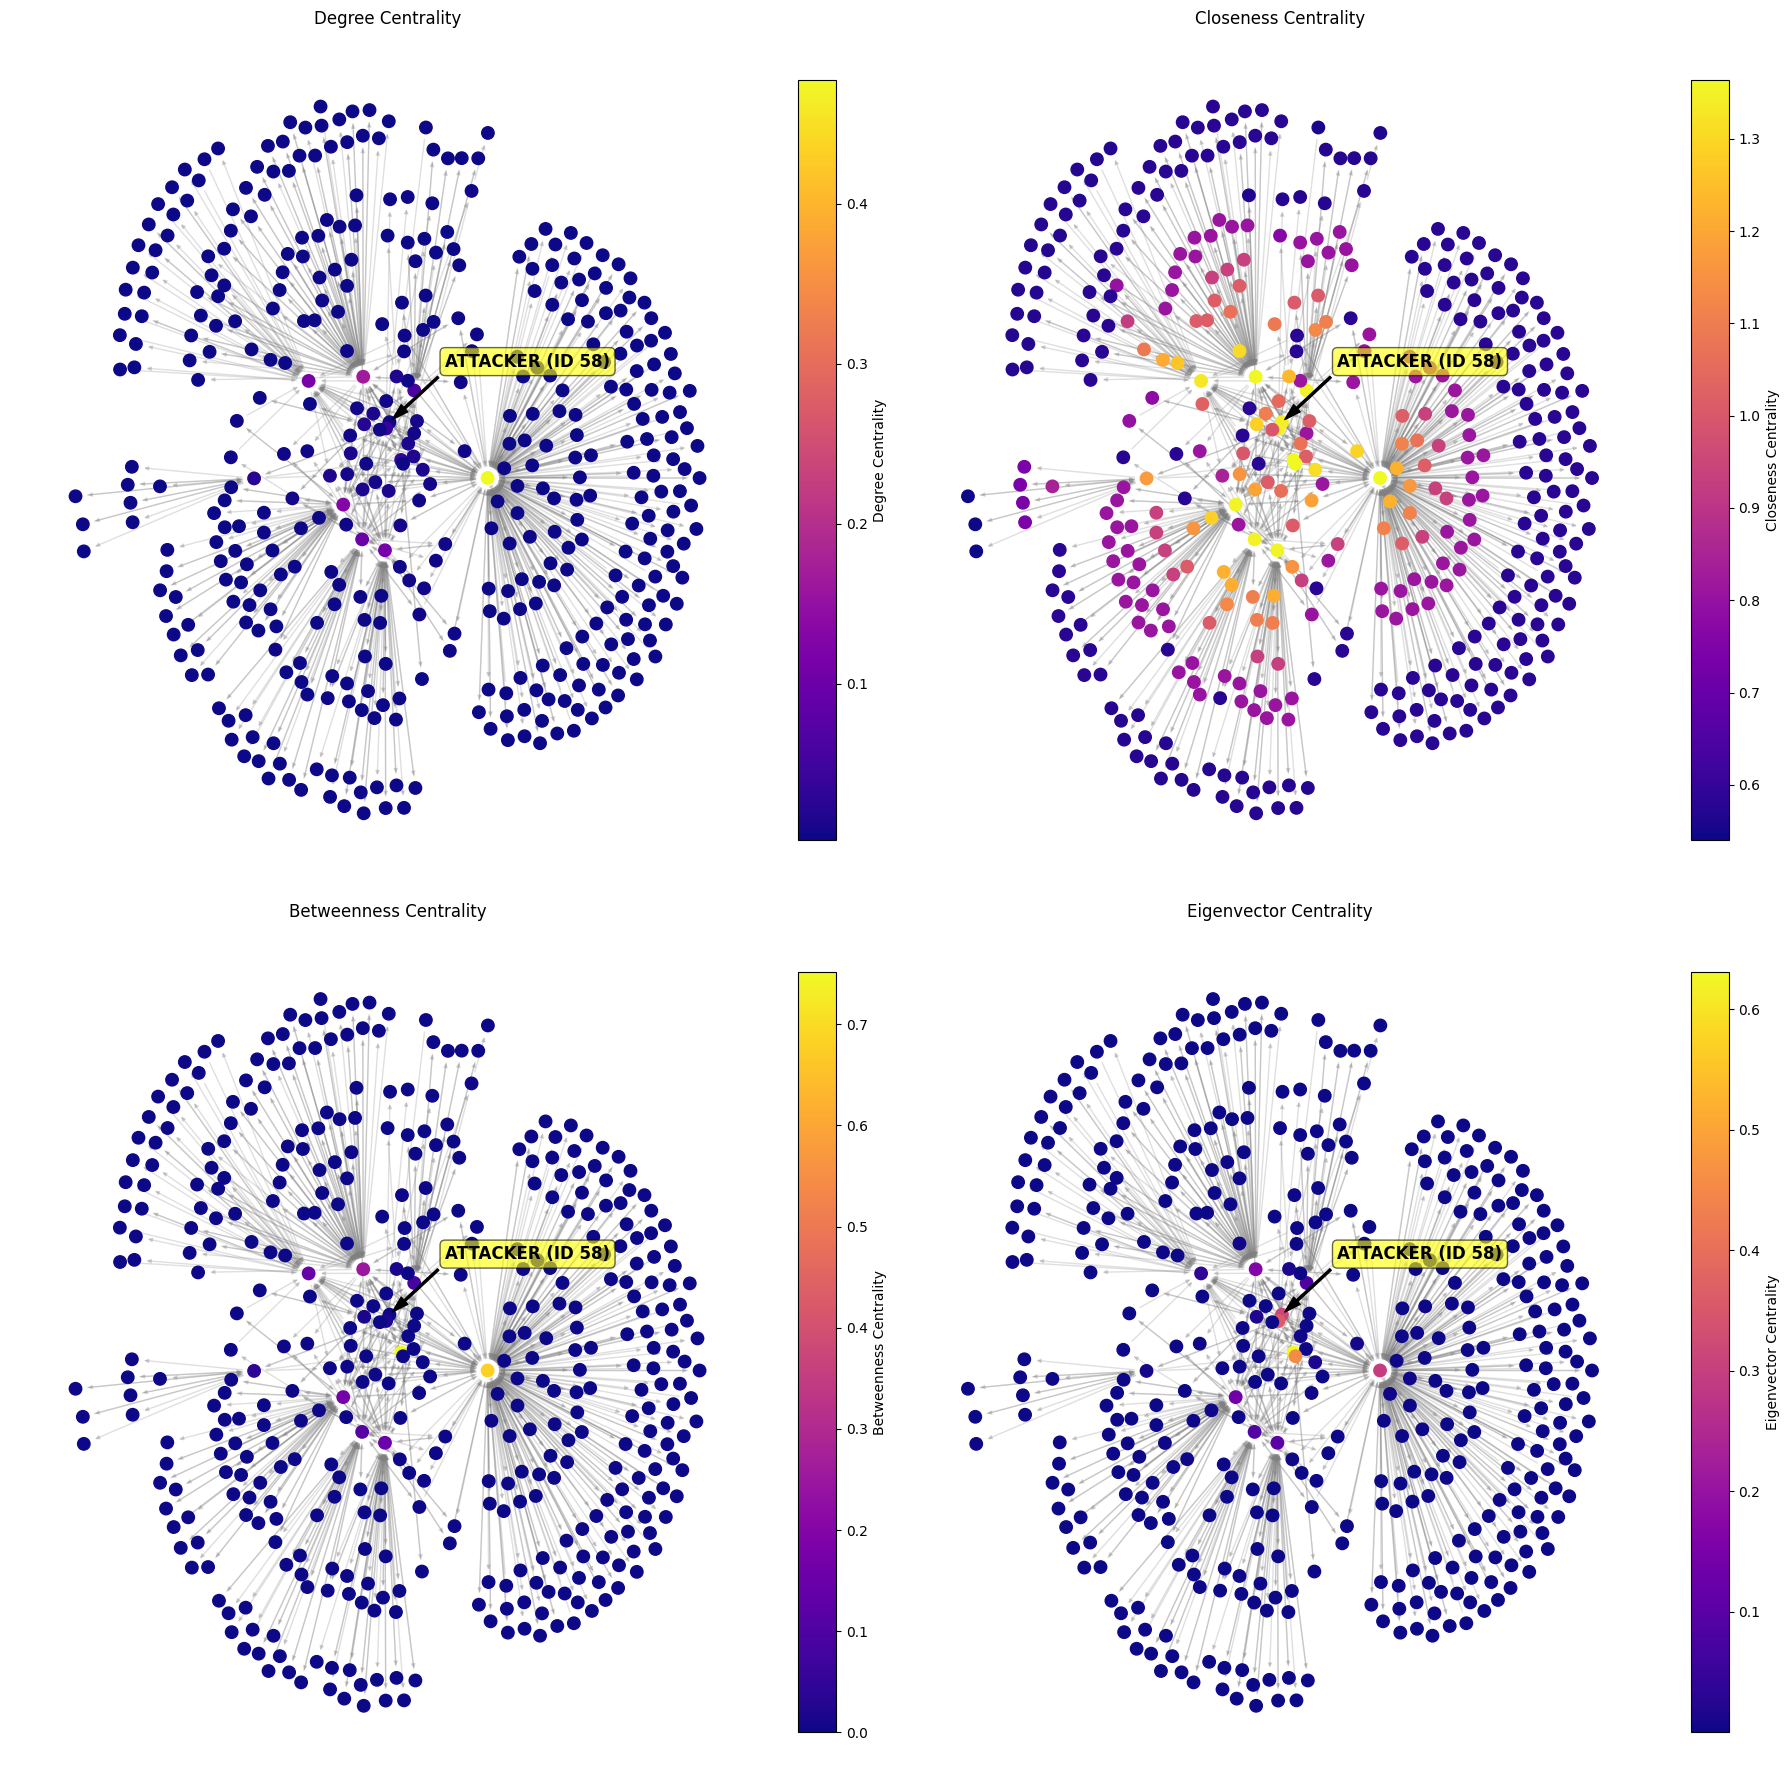

In [21]:
# Viene effetuato il calcolo su H ovvero la componente debolmente connessa più grande definita prima
U = H.to_undirected()

# Posizione unica (calcolata una sola volta)
pos = nx.spring_layout(U, seed=42)

plt.figure(figsize=(18, 18))

node_size = 80          # per 700+ nodi deve essere piccolo
with_labels = False     # etichette OFF su grafi grandi (se vuoi, le metti solo su top-k)
edge_color = "gray"
edge_alpha = 0.25

# Funzione helper per un pannello
def draw_centrality_subplot(ax, graph, pos, cent_dict, title):
    values = [cent_dict.get(node, 0.0) for node in graph.nodes()]

    nx.draw_networkx_nodes(
        graph, pos,
        node_color=values,
        node_size=node_size,
        cmap="plasma",
        ax=ax
    )
    nx.draw_networkx_edges(
        graph, pos,
        edge_color=edge_color,
        alpha=edge_alpha,
        arrows=True,
        arrowsize=6,
        ax=ax
    )

    if with_labels:
        nx.draw_networkx_labels(graph, pos, font_size=6, ax=ax)

    sm = plt.cm.ScalarMappable(
        cmap="plasma",
        norm=plt.Normalize(vmin=min(values), vmax=max(values))
    )
    sm.set_array([])
    plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, label=title)

    ax.set_title(title)
    ax.axis("off")

# 1) Degree
ax = plt.subplot(2, 2, 1)
draw_centrality_subplot(ax, H, pos, degree_centrality, "Degree Centrality")

# 2) Closeness
ax = plt.subplot(2, 2, 2)
draw_centrality_subplot(ax, H, pos, closeness_centrality, "Closeness Centrality")

# 3) Betweenness
ax = plt.subplot(2, 2, 3)
draw_centrality_subplot(ax, H, pos, betweenness_centrality, "Betweenness Centrality")

# 4) Eigenvector
ax = plt.subplot(2, 2, 4)
draw_centrality_subplot(ax, H, pos, eigenvector_centrality, "Eigenvector Centrality")

target_node = 58 # L'ID dell'attaccante che hai identificato
if target_node in pos:
    # Recuperiamo le coordinate del nodo
    x, y = pos[target_node]
    
    # Lista dei subplot su cui vogliamo mettere la freccia (es. tutti e 4)
    for i, ax in enumerate(plt.gcf().axes[::2]): # Prende gli assi dei grafi, non delle colorbar
        ax.annotate(
            "ATTACKER (ID 58)",
            xy=(x, y), 
            xytext=(40, 40), # Sposta il testo di 40 punti
            textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=7),
            fontsize=12, 
            fontweight='bold',
            color='black',
            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", alpha=0.6)
        )

plt.tight_layout()
plt.show()


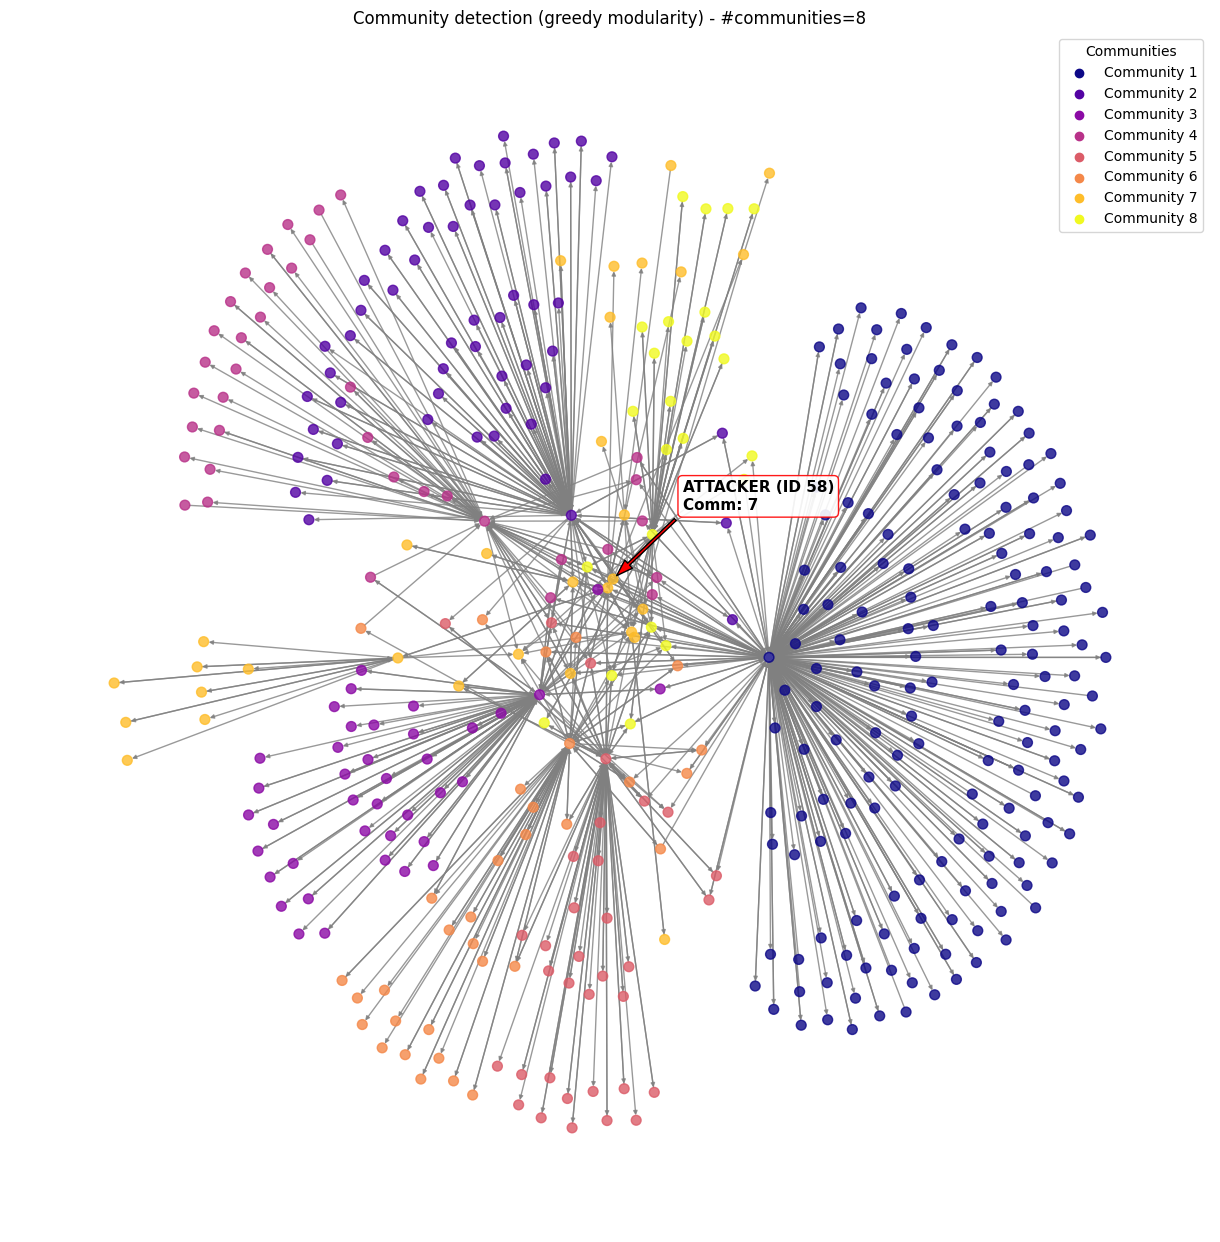

In [22]:
pos = nx.spring_layout(U, seed=42)

#Community detection
communities = list(greedy_modularity_communities(U))

community_colors = plt.cm.plasma(np.linspace(0, 1, len(communities)))
node_color = {}

for i, community in enumerate(communities):
    for node in community:
        node_color[node] = community_colors[i]

colors = [node_color.get(node, (0.7, 0.7, 0.7, 1.0)) for node in U.nodes]

# Plot
plt.figure(figsize=(12, 12))
nx.draw(
    H, pos,
    node_color=colors,
    with_labels=False,      
    node_size=50,
    edge_color="gray",
    alpha=0.8,
    arrows=True,
    arrowsize=6
)

# Legenda: solo se comunità poche (altrimenti è inutilizzabile)
MAX_LEGEND = 12
if len(communities) <= MAX_LEGEND:
    for i in range(len(communities)):
        plt.scatter([], [], color=community_colors[i], label=f'Community {i+1}')
    plt.legend(title="Communities", loc="best")

plt.title(f"Community detection (greedy modularity) - #communities={len(communities)}")
plt.axis("off")
target_node = 58
if target_node in pos:
    plt.annotate(
        f"ATTACKER (ID 58)\nComm: {next(i+1 for i, c in enumerate(communities) if target_node in c)}",
        xy=pos[target_node],
        xytext=(50, 50),
        textcoords='offset points',
        arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
        fontsize=11,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9)
    )
plt.show()

ANALISI DELLE STRUTTURE PER LA PORT SCAN

In [23]:
# Preparazione del grafo non diretto
U = H.to_undirected()
attacker_id = 58  # Il tuo attaccante identificato

# Ricerca di tutte le clique nel grafo
cliques = list(nx.find_cliques(U))

# Analisi Genrale
clique_count = len(cliques)
max_clique_size = max(len(c) for c in cliques)
largest_cliques = [c for c in cliques if len(c) == max_clique_size]

# Analisi MIRATA sull'Attaccante (Nodo 58)
attacker_cliques = [c for c in cliques if attacker_id in c]
attacker_max_clique = max(len(c) for c in attacker_cliques) if attacker_cliques else 0

# Calcolo del Clustering Coefficient locale (Misura di "vuoto" strutturale)
# Se è vicino a 0, l'attaccante è isolato socialmente nonostante l'alto grado
cc_attacker = nx.clustering(U, attacker_id)

print(f"ANALISI GENERALE")
print(f"Numero totale di clique nella rete: {clique_count}")
print(f"Dimensione massima clique (Benign): {max_clique_size}")
print(f"Esempio di clique principale: {largest_cliques[0] if largest_cliques else 'N/A'}")

print(f"\nANALISI SPECIFICA ATTACCANTE (ID {attacker_id}) ")
print(f"L'attaccante partecipa a {len(attacker_cliques)} clique.")
print(f"Dimensione massima clique per l'attaccante: {attacker_max_clique}")
print(f"Clustering Coefficient dell'attaccante: {cc_attacker:.6f}")

# Verifica rapida: l'attaccante è nella clique più grande?
is_in_main = any(attacker_id in c for c in largest_cliques)
print(f"L'attaccante fa parte della clique principale? {'SÌ' if is_in_main else 'NO'}")

ANALISI GENERALE
Numero totale di clique nella rete: 505
Dimensione massima clique (Benign): 4
Esempio di clique principale: [6, 38, 59, 111]

ANALISI SPECIFICA ATTACCANTE (ID 58) 
L'attaccante partecipa a 2 clique.
Dimensione massima clique per l'attaccante: 2
Clustering Coefficient dell'attaccante: 0.000000
L'attaccante fa parte della clique principale? NO


In [24]:
# Calcolo globale dei triangoli
triangles_dict = nx.triangles(U)
total_triangles = sum(triangles_dict.values()) // 3

# Calcolo delle triadi aperte
total_triads_all = sum(d * (d - 1) // 2 for n, d in U.degree())
total_open_triads = total_triads_all - (total_triangles * 3) # Sottraiamo i triangoli (ogni triangolo conta come 3 triadi chiuse)

# Focus sull'attaccante
attacker_id = 58 
d_att = U.degree(attacker_id)
attacker_total_triads = d_att * (d_att - 1) // 2
attacker_closed_triads = triangles_dict.get(attacker_id, 0)
attacker_open_triads = attacker_total_triads - attacker_closed_triads

print(f"ANALISI DELLE TRIADI")
print(f"Rete Generale:")
print(f"  - Triadi Chiuse (Triangoli): {total_triangles}")
print(f"  - Triadi Aperte (Wedges):   {total_open_triads}")

print(f"\nFocus Attaccante (ID {attacker_id}):")
print(f"  - Triadi Totali: {attacker_total_triads}")
print(f"  - Triadi Chiuse: {attacker_closed_triads}")
print(f"  - Triadi Aperte: {attacker_open_triads}")

#Interpretazione
if attacker_total_triads > 0:
    ratio = attacker_closed_triads / attacker_total_triads
    print(f"\nPercentuale di chiusura dell'attaccante: {ratio:.2%}")

ANALISI DELLE TRIADI
Rete Generale:
  - Triadi Chiuse (Triangoli): 21
  - Triadi Aperte (Wedges):   27516

Focus Attaccante (ID 58):
  - Triadi Totali: 1
  - Triadi Chiuse: 0
  - Triadi Aperte: 1

Percentuale di chiusura dell'attaccante: 0.00%


In [25]:
# Calcolo della struttura k-core 
k_core_dict = {}
max_degree = max(dict(U.degree()).values())

for k in range(1, max_degree + 1):
    k_core = nx.k_core(U, k=k)
    if k_core.number_of_nodes() > 0:
        k_core_dict[k] = k_core

k_core_summary = {k: core.number_of_nodes() for k, core in k_core_dict.items()}
print("k-core summary (k : numero nodi):", k_core_summary)

max_k = max(k_core_dict.keys())
largest_k_core = k_core_dict[max_k]

print("Max k della rete:", max_k)
print("Nodi nel largest k-core (core massimo):", list(largest_k_core.nodes))


#Analisi specifica sull'attaccante
attacker_id = 58
max_k_attacker = 0

# Cerchiamo il k più alto a cui partecipa l'attaccante
for k, core in k_core_dict.items():
    if attacker_id in core.nodes():
        max_k_attacker = k

print(f"\nCONCLUSIONI STRUTTURALI")
print(f"L'attaccante (ID 58) appartiene al k-core massimo k = {max_k_attacker}")
print(f"Il k-core massimo dell'intera rete è k = {max_k}")

if max_k_attacker < max_k:
    print("Conclusione: L'attaccante è numericamente dominante (alto degree) ma strutturalmente isolato dal core della rete (k-core basso).")
elif max_k_attacker == max_k:
    print("Conclusione: L'attaccante è riuscito a penetrare o fa parte del core densamente connesso della rete.")

k-core summary (k : numero nodi): {1: 420, 2: 59, 3: 35, 4: 23, 5: 15}
Max k della rete: 5
Nodi nel largest k-core (core massimo): [128, 1, 3, 6, 38, 71, 59, 109, 79, 16, 49, 18, 111, 23, 27]

CONCLUSIONI STRUTTURALI
L'attaccante (ID 58) appartiene al k-core massimo k = 2
Il k-core massimo dell'intera rete è k = 5
Conclusione: L'attaccante è numericamente dominante (alto degree) ma strutturalmente isolato dal core della rete (k-core basso).


In [26]:
# Analisi Ego-network per l'attaccante (Nodo 58) e un nodo legittimo (Nodo 1)
attacker_node = 58
legit_node = 1 

# Generazione Ego-network dell'attaccante
ego_attacker = nx.ego_graph(U, attacker_node)
print(f"Ego-network ATTACCANTE (Nodo {attacker_node})")
print(f"Nodi raggiunti direttamente: {ego_attacker.number_of_nodes()}")
print(f"Archi totali nella ego-net: {ego_attacker.number_of_edges()}")

#  Generazione Ego-network del nodo legittimo (per confronto)
if legit_node in U:
    ego_legit = nx.ego_graph(U, legit_node)
    print(f"\nEgo-network LEGITTIMA (Nodo {legit_node})")
    print(f"Nodi raggiunti direttamente: {ego_legit.number_of_nodes()}")
    print(f"Archi totali nella ego-net: {ego_legit.number_of_edges()}")

Ego-network ATTACCANTE (Nodo 58)
Nodi raggiunti direttamente: 3
Archi totali nella ego-net: 2

Ego-network LEGITTIMA (Nodo 1)
Nodi raggiunti direttamente: 201
Archi totali nella ego-net: 201


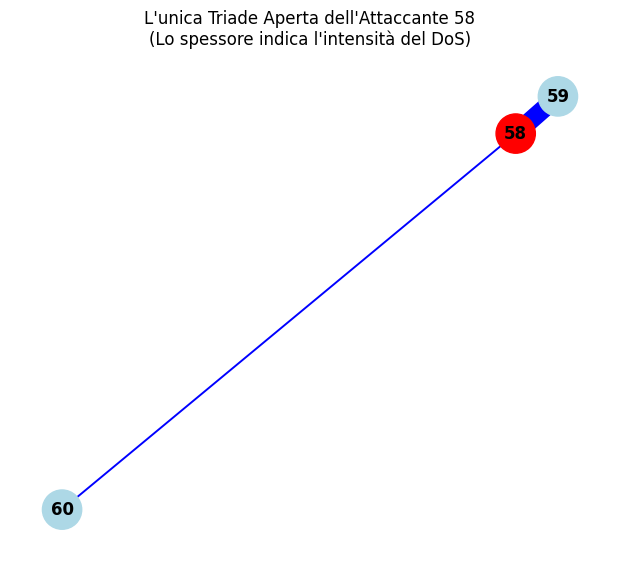

Flussi tra 58 e 59: 717
Flussi tra 58 e 60: 1


In [27]:
# 1) Identificazione dei nodi coinvolti nell'attacco
u = 58 # L'attaccante
# Troviamo i vicini del nodo 58 per identificare la triade
vicini = list(U.neighbors(u))

if len(vicini) < 2:
    print(f"Il nodo {u} ha solo {len(vicini)} vicino/i. Impossibile formare una triade.")
else:
    # 2) Estrazione della triade aperta dell'attaccante
    # Prendiamo i primi due vicini che formano la triade aperta risultante (v, x)
    v, x = vicini[0], vicini[1]
    
    trio = [u, v, x]
    subU = U.subgraph(trio)
    
    # 3) Visualizzazione con enfasi sul Peso (Weight)
    plt.figure(figsize=(6, 5))
    pos = nx.spring_layout(subU, seed=42)
    
    # Calcoliamo gli spessori in base al peso degli archi (normalizzati per la visualizzazione)
    weights = [subU[edge[0]][edge[1]]['weight'] for edge in subU.edges()]
    # Normalizzazione per evitare archi troppo giganti (es. logaritmica o scalandoli)
    import numpy as np
    scaled_widths = [np.log1p(w) * 2 for w in weights] 

    nx.draw(
        subU, pos,
        with_labels=True,
        node_size=800,
        node_color=["red" if n == u else "lightblue" for n in subU.nodes()],
        edge_color="blue",
        width=scaled_widths,
        font_weight="bold"
    )
    
    plt.title(f"L'unica Triade Aperta dell'Attaccante {u}\n(Lo spessore indica l'intensità del DoS)")
    plt.axis("off")
    plt.show()

    # Stampiamo i pesi per documentazione
    for edge in subU.edges(data=True):
        print(f"Flussi tra {edge[0]} e {edge[1]}: {edge[2]['weight']}")

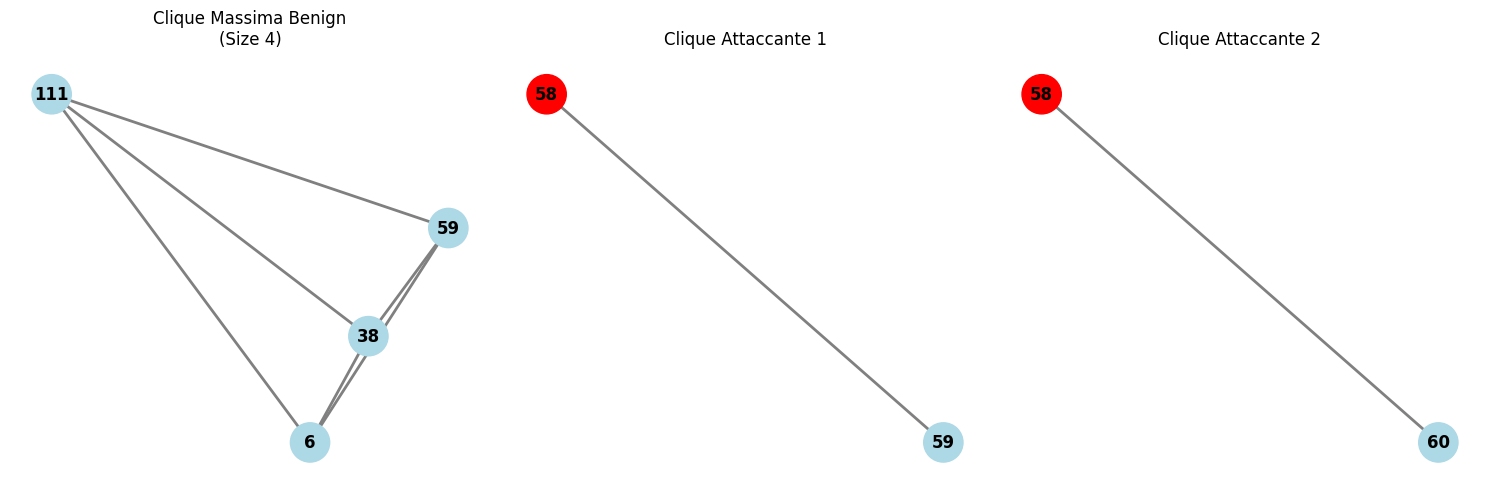

In [28]:
# Identificazione delle strutture
# Prendiamo la prima clique massima (Benign)
max_size = max(len(c) for c in cliques)
max_clique_benign = [c for c in cliques if len(c) == max_size][0]

# Prendiamo le clique dell'attaccante (ID 58)
attacker_id = 58
attacker_cliques = [c for c in cliques if attacker_id in c]

# Uniamo le strutture da plottare: la clique massima benigna e le clique dell'attaccante
to_plot = [max_clique_benign] + attacker_cliques[:2] # Massimo 3 grafici totali
titles = [f"Clique Massima Benign\n(Size {max_size})", "Clique Attaccante 1", "Clique Attaccante 2"]

fig, axes = plt.subplots(1, len(to_plot), figsize=(5 * len(to_plot), 5))

for i, nodes in enumerate(to_plot):
    # Creiamo il sottografo
    C = U.subgraph(nodes)
    pos = nx.spring_layout(C, seed=42)
    
    # Colore diverso per distinguere l'attaccante
    node_colors = []
    for node in nodes:
        if node == attacker_id:
            node_colors.append("red") # Evidenziamo il Nodo 58
        else:
            node_colors.append("lightblue")

    nx.draw(
        C, pos,
        with_labels=True,
        node_size=800,
        node_color=node_colors,
        edge_color="gray",
        font_weight="bold",
        width=2,
        ax=axes[i]
    )

    axes[i].set_title(titles[i], fontsize=12, pad=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Core number massimo della rete: 5
Core number dell'attaccante (ID 58): 2


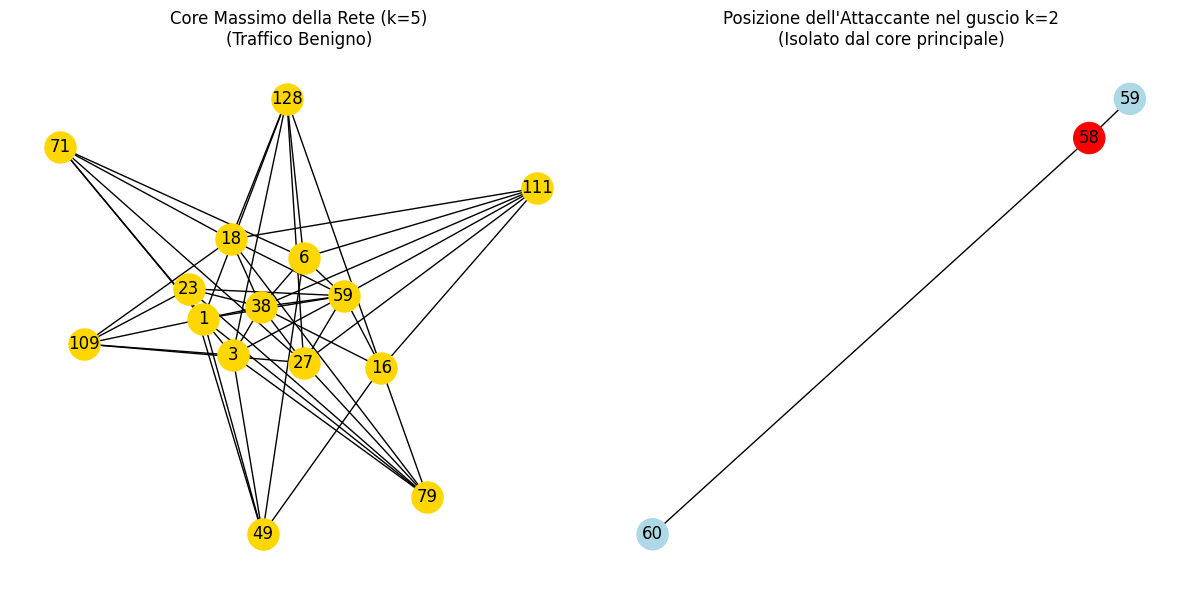

In [29]:
# Recupero dei dati core
core_numbers = nx.core_number(U)
max_core_network = max(core_numbers.values()) # Questo è il k=5
attacker_core = core_numbers.get(58, 0)      # Questo è il k=2

# Creazione dei sottografi
G_max_core = nx.k_core(U, k=max_core_network) # Il vero core (k=5)
# Creazione del k-core dell'attaccante (k=2)
G_attacker_core = nx.k_core(U, k=attacker_core) 

print(f"Core number massimo della rete: {max_core_network}")
print(f"Core number dell'attaccante (ID 58): {attacker_core}")

# Visualizzazione Comparativa
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pannello 1: Il vero Core della Rete (k=5)
pos1 = nx.spring_layout(G_max_core, seed=42)
nx.draw(G_max_core, pos1, with_labels=True, node_size=500, node_color="gold", ax=axes[0])
axes[0].set_title(f"Core Massimo della Rete (k={max_core_network})\n(Traffico Benigno)")

# Pannello 2: Core dell'attaccante (k=2) 
# Mostriamo solo l'attaccante e i suoi vicini immediati nel k-core 2 per chiarezza
nodes_to_show = [n for n in G_attacker_core.nodes() if n == 58 or n in list(U.neighbors(58))[:10]]
G_sub = U.subgraph(nodes_to_show)

pos2 = nx.spring_layout(G_sub, seed=42)
colors = ["red" if n == 58 else "lightblue" for n in G_sub.nodes()]
nx.draw(G_sub, pos2, with_labels=True, node_size=500, node_color=colors, ax=axes[1])
axes[1].set_title(f"Posizione dell'Attaccante nel guscio k={attacker_core}\n(Isolato dal core principale)")

plt.tight_layout()
plt.show()

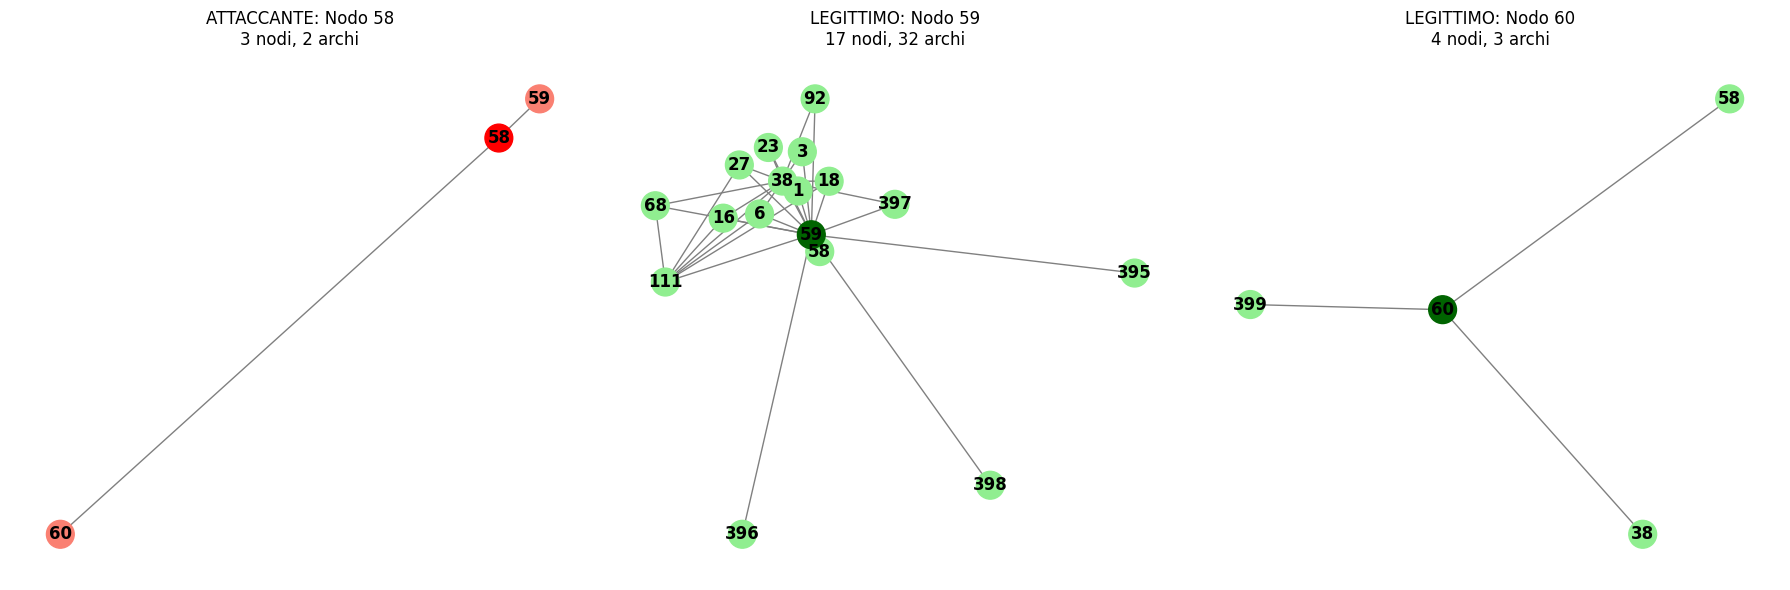

In [30]:
attacker_id = 58
attacker_neighbor = [59, 60]  

# Lista finale per il plot: Attaccante + i nodi vicini
nodes_to_plot = [attacker_id] + attacker_neighbor

# Plot dei 3 ego network
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, n in zip(axes, nodes_to_plot):
    ego = nx.ego_graph(U, n)
    pos = nx.spring_layout(ego, seed=42)

    # Colore speciale per l'attaccante
    base_color = "salmon" if n == attacker_id else "lightgreen"
    
    # Evidenziamo il nodo "Ego" (il centro) con un colore diverso
    node_colors = ["red" if node == n and n == attacker_id else 
                   "darkgreen" if node == n else base_color 
                   for node in ego.nodes()]

    nx.draw(
        ego, pos,
        with_labels=True,
        node_size=400,
        node_color=node_colors,
        edge_color="gray",
        font_weight="bold",
        ax=ax
    )
    
    title_prefix = "ATTACCANTE" if n == attacker_id else "LEGITTIMO"
    ax.set_title(
        f"{title_prefix}: Nodo {n}\n"
        f"{ego.number_of_nodes()} nodi, {ego.number_of_edges()} archi",
        fontsize=12
    )
    ax.axis("off")

plt.tight_layout()
plt.show()